In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [23]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load sample data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5351,00028873_001.png,No Finding,1,28873,015Y,M,PA,1804,1758,0.194311,0.194311
2467,00012378_000.png,Cardiomegaly|Effusion,0,12378,063Y,M,PA,2990,2948,0.143000,0.143000
3368,00016607_035.png,No Finding,35,16607,064Y,M,AP,2500,2048,0.168000,0.168000


In [24]:
## EDA
# Todo 
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
31195,00008124_000.png,No Finding,0,8124,34,F,PA,2048,2500,0.168,0.168,NaN
74113,00018224_015.png,Pneumothorax,15,18224,59,M,AP,2500,2048,0.168,0.168,NaN
14005,00003615_001.png,No Finding,1,3615,57,F,AP,2500,2048,0.171,0.171,NaN
20812,00005563_000.png,No Finding,0,5563,46,F,AP,2500,2048,0.171,0.171,NaN
15605,00004092_001.png,No Finding,1,4092,62,F,PA,2048,2500,0.168,0.168,NaN


## Demographics

male count: 63340
female count: 48780


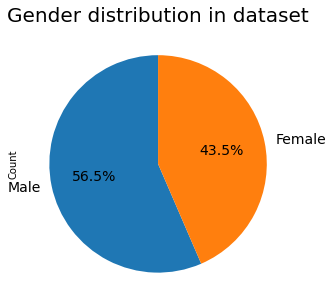

In [25]:
gender = {}
male_cnt = len(all_xray_df[all_xray_df["Patient Gender"] == "M"])
gender['Count'] = [male_cnt, len(all_xray_df) - male_cnt]
gender['Gender'] = ['Male', 'Female']
gender_df = pd.DataFrame(gender, columns = ['Gender', 'Count'])
gender_df.plot.pie(y = 'Count', autopct='%1.1f%%', startangle=90, shadow=False, labels=gender_df['Gender'], legend = False, fontsize=14, figsize=(5, 5))
plt.title("Gender distribution in dataset", fontsize=20)
print("male count:", male_cnt)
print("female count:", len(all_xray_df)-male_cnt)

Text(0, 0.5, 'Frequency')

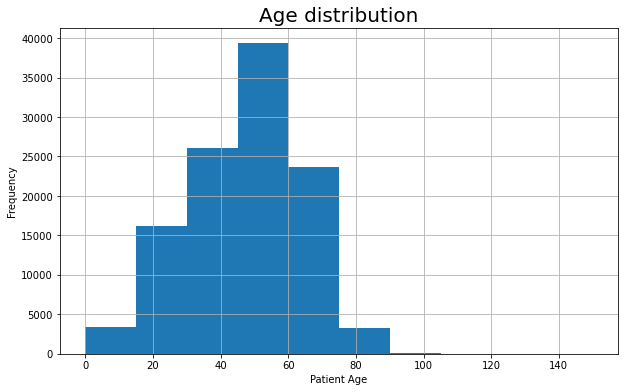

In [26]:
plt.figure(figsize=(10,6))
all_xray_df["Patient Age"].hist(bins=10, range=[0, 150], align='mid')
plt.title("Age distribution", fontsize=20)
plt.xlabel("Patient Age")
plt.ylabel("Frequency")

anteroposterior: 44810
posteroanterior: 67310


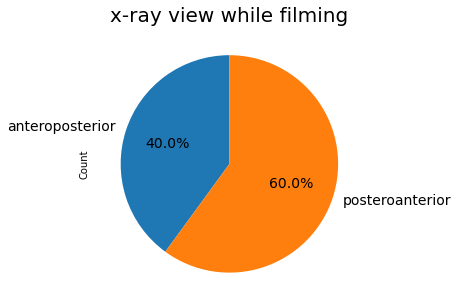

In [27]:
#Position
ap = len(all_xray_df[all_xray_df["View Position"] == "AP"])
pa = len(all_xray_df) - ap
position = {"Position": ["anteroposterior", "posteroanterior"], "Count": [ap, pa]}
position_df = pd.DataFrame(position, columns = ['Position', 'Count'])
position_df.plot.pie(y = 'Count', autopct='%1.1f%%', startangle=90, shadow=False, labels=position_df['Position'], legend = False, fontsize=14, figsize=(5, 5))
plt.title("x-ray view while filming", fontsize=20)
print("anteroposterior:", ap)
print("posteroanterior:", pa)

In [28]:
pneumonia_cnt = 0
for label in all_xray_df['Finding Labels']:
    if "Pneumonia" in label:
        pneumonia_cnt += 1
print("Number of pneumonia cases: {}/{}".format(pneumonia_cnt, len(all_xray_df)))
print("Number of non-pneumonia cases: {}/{}".format(len(all_xray_df)-pneumonia_cnt, len(all_xray_df)))

Number of pneumonia cases: 1431/112120
Number of non-pneumonia cases: 110689/112120


In [29]:
# Creating seperate column for each disease
df = all_xray_df.copy()
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for label in labels:
    if label:
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)
    
df.iloc[0]

Image Index                    00000001_000.png
Finding Labels                     Cardiomegaly
Follow-up #                                   0
Patient ID                                    1
Patient Age                                  58
Patient Gender                                M
View Position                                PA
OriginalImage[Width                        2682
Height]                                    2749
OriginalImagePixelSpacing[x               0.143
y]                                        0.143
Unnamed: 11                                 NaN
Atelectasis                                   0
Cardiomegaly                                  1
Consolidation                                 0
Edema                                         0
Effusion                                      0
Emphysema                                     0
Fibrosis                                      0
Hernia                                        0
Infiltration                            

In [30]:
# count of labels
print("Number of labels: {}".format(len(labels)))
df[labels].sum()

Number of labels: 15


Atelectasis           11559
Cardiomegaly           2776
Consolidation          4667
Edema                  2303
Effusion              13317
Emphysema              2516
Fibrosis               1686
Hernia                  227
Infiltration          19894
Mass                   5782
No Finding            60361
Nodule                 6331
Pleural_Thickening     3385
Pneumonia              1431
Pneumothorax           5302
dtype: int64

Pneumonia case: 1431


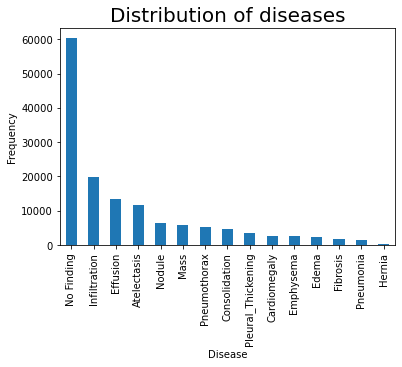

In [31]:
plt.figure()
df[labels].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of diseases", fontsize=20)
plt.xlabel("Disease")
plt.ylabel("Frequency")
print("Pneumonia case:", df["Pneumonia"].sum())

Text(0.5, 1.0, 'Age distribution for pneumonia cases')

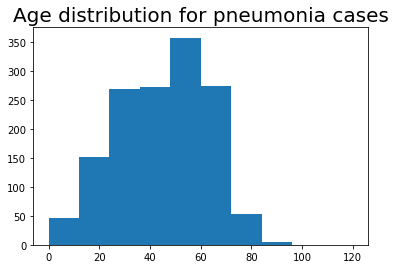

In [32]:
plt.figure()
plt.hist([df[df["Pneumonia"]==1]['Patient Age'].values], bins = 10, range=[0, 120])
plt.title('Age distribution for pneumonia cases', fontsize=20)

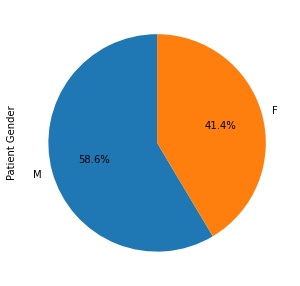

In [33]:
plt.figure()
df[df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, figsize=(5,5))

### No finding image Pixel-level assessment

No Finding


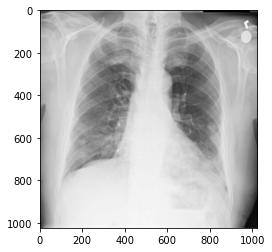

In [34]:
import pydicom

dcm = pydicom.dcmread('test1.dcm')
plt.imshow(dcm.pixel_array,cmap='gray')
print(dcm.StudyDescription)

Text(0.5, 1.0, 'Image Pixel Intensity')

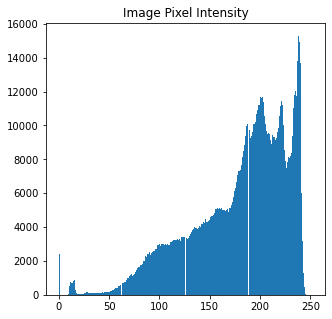

In [35]:
plt.figure(figsize=(5,5))
plt.hist(dcm.pixel_array.ravel(), bins = 256)
plt.title('Image Pixel Intensity')

mean intensity: 180.0586576461792
std intensity: 47.89115072730743


Text(0.5, 1.0, 'Normalized')

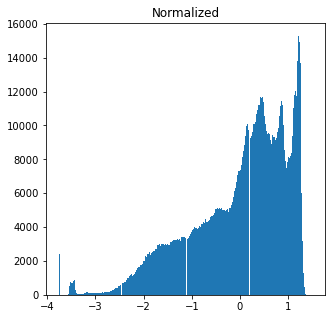

In [36]:
mean_intensity = np.mean(dcm.pixel_array)
print("mean intensity:", mean_intensity)
std_intensity = np.std(dcm.pixel_array)
print("std intensity:",std_intensity)
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')

### Disease states of interest

In [37]:
import random
bbox = pd.read_csv('/data/BBox_List_2017.csv')
pn_case = bbox[bbox['Finding Label'] == "Pneumonia"]
pn_case = pn_case.iloc[random.randint(0,len(pn_case))]["Image Index"]

In [38]:
import os
file_loc = {}
for dirs,subdirs, files in os.walk('/data/'):
    for file in files:
        file_loc[file] = os.path.join(dirs, file)
file_loc[pn_case]

'/data/images_008/images/00016705_006.png'

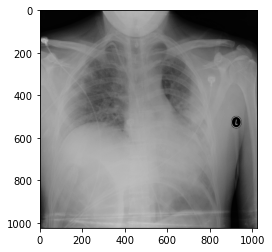

In [39]:
from PIL import Image
img = Image.open(file_loc[pn_case])
plt.imshow(img,cmap='gray')

Text(0.5, 1.0, 'Image Pixel Intensity')

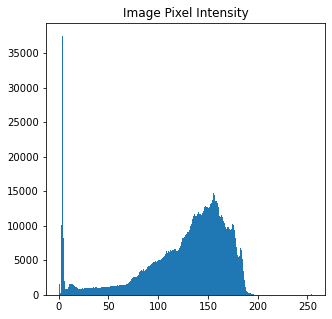

In [40]:
pixels = np.array(img.getdata())
plt.figure(figsize=(5,5))
plt.hist(pixels.ravel(), bins = 256)
plt.title('Image Pixel Intensity')

mean intensity: 124.53036403656006
std intensity: 47.70228942518576


Text(0.5, 1.0, 'Normalized')

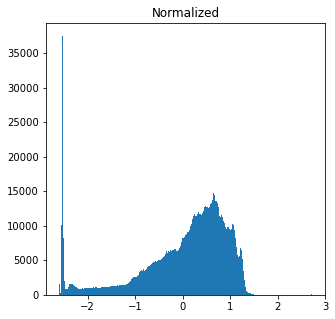

In [41]:
mean_intensity = np.mean(pixels)
print("mean intensity:", mean_intensity)
std_intensity = np.std(pixels)
print("std intensity:",std_intensity)
new_img = pixels.copy()
new_img = (new_img - mean_intensity)/std_intensity
plt.figure(figsize=(5,5))
plt.hist(new_img.ravel(), bins = 256)
plt.title('Normalized')

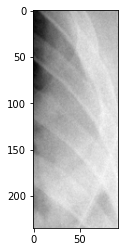

In [46]:
## im.crop((left, top, right, bottom))
temp = bbox[(bbox['Image Index'] == pn_case) & (bbox['Finding Label'] == "Pneumonia")]
im = img.crop((int(temp['Bbox [x']), int(temp['y']), (int(temp['Bbox [x'])+int(temp['w'])+1), (int(temp['y'])+int(temp['h]']))))
plt.imshow(im, cmap='gray')

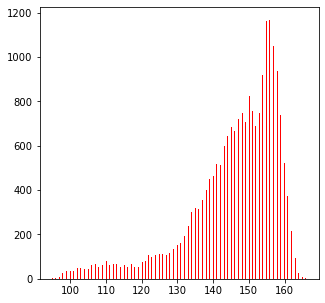

In [49]:
plt.figure(figsize=(5,5))
plt.hist(np.array(im.getdata()).ravel(), bins = 256,color='red')
plt.show()